In [7]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import mltools as ml
import math
import csv

In [8]:
from numpy import asarray as arr
from numpy import asmatrix as mat
from numpy import atleast_2d as twod
from itertools import islice

### Load data

In [9]:
data_train = pd.read_csv('./data/adult.data',delimiter=',',skipinitialspace=True)
data_test = pd.read_csv('./data/adult.test',delimiter=',',skipinitialspace=True)

In [10]:
orig_keys = data_train.keys()
print(orig_keys)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')


### Check for missing Value

In [11]:
data_train.iloc[[27]]    # See id 27 has missing value in workclass

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K


In [12]:
#n_missing_number_Xtr[[1,6,13]]

In [13]:
n_missing_number_Xtr = np.array([]) 
n_missing_lst_Xtr    = np.array([])
n_missing_number_Xte = np.array([]) 
n_missing_lst_Xte    = np.array([])
for key in data_train.keys():
    n_missing_number_Xtr= np.append(n_missing_number_Xtr,sum(data_train[key] == '?'))                                            
    n_missing_lst_Xtr = np.append(n_missing_lst_Xtr,str('%.2f'% (100*np.mean(data_train[key] == '?')))+'%')
    n_missing_number_Xte= np.append(n_missing_number_Xte,sum(data_test[key] == '?'))                                            
    n_missing_lst_Xte = np.append(n_missing_lst_Xte,str('%.2f'% (100*np.mean(data_test[key] == '?')))+'%')
# print('number of missing values (%s): %d' % (key, n_missing))
new_dataframe =  pd.DataFrame(
{   "Training Missing number":n_missing_number_Xtr[[1,6,13]],
    "Training Missing Percent": n_missing_lst_Xtr[[1,6,13]],
    "Test     Missing number":n_missing_number_Xte[[1,6,13]],
    "Test     Missing Percent": n_missing_lst_Xte[[1,6,13]]},
index = orig_keys[[1,6,13]] )
new_dataframe

C:\Users\Yushang\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Training Missing number,Training Missing Percent,Test Missing number,Test Missing Percent
workclass,1836.0,5.64%,963.0,5.91%
occupation,1843.0,5.66%,966.0,5.93%
native-country,583.0,1.79%,274.0,1.68%


In [14]:
# convert salary to binary values
salary_labels = data_train['salary'].unique()
for i,l in enumerate(salary_labels):
    data_train.loc[data_train['salary'] == l,'salary'] = i%2
for i,l in enumerate(data_test['salary'].unique()):
    data_test.loc[data_test['salary'] == l,'salary'] = i%2
# convert salary to binary values
gender_labels = data_train['sex'].unique()
for i,l in enumerate(gender_labels):
    data_train.loc[data_train['sex'] == l,'sex'] = i
    data_test.loc[data_test['sex'] == l,'sex'] = i%2

In [15]:
data_train.describe()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,salary
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,0.330795,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,0.470506,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,1.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,1.000000,99999.000000,4356.000000,99.000000,1.000000


In [16]:
data_test.describe()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,salary
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,0.332965,1081.905104,87.899269,40.392236,0.236226
std,13.849187,1.057149e+05,2.567545,0.471289,7583.935968,403.105286,12.479332,0.424776
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.383840e+05,12.000000,1.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,1.000000,99999.000000,3770.000000,99.000000,1.000000


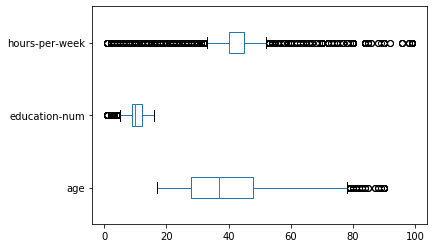

In [17]:
data_test[['age','education-num', 
             'hours-per-week']].plot.box(vert=False)

### Remove Outliers

In [18]:
print(data_train[data_train['age']>80].shape)
print(data_train[data_train['education-num']<3].shape)

(99, 15)
(219, 15)


In [19]:
# remove rows with age>80
data_train = data_train[data_train['age']<80]
# remove rows with eduacation num <5
data_train = data_train[data_train['education-num'] >= 3]  

In [20]:
data_train.shape

(32225, 15)

### Scatter & Density Plot of Features 

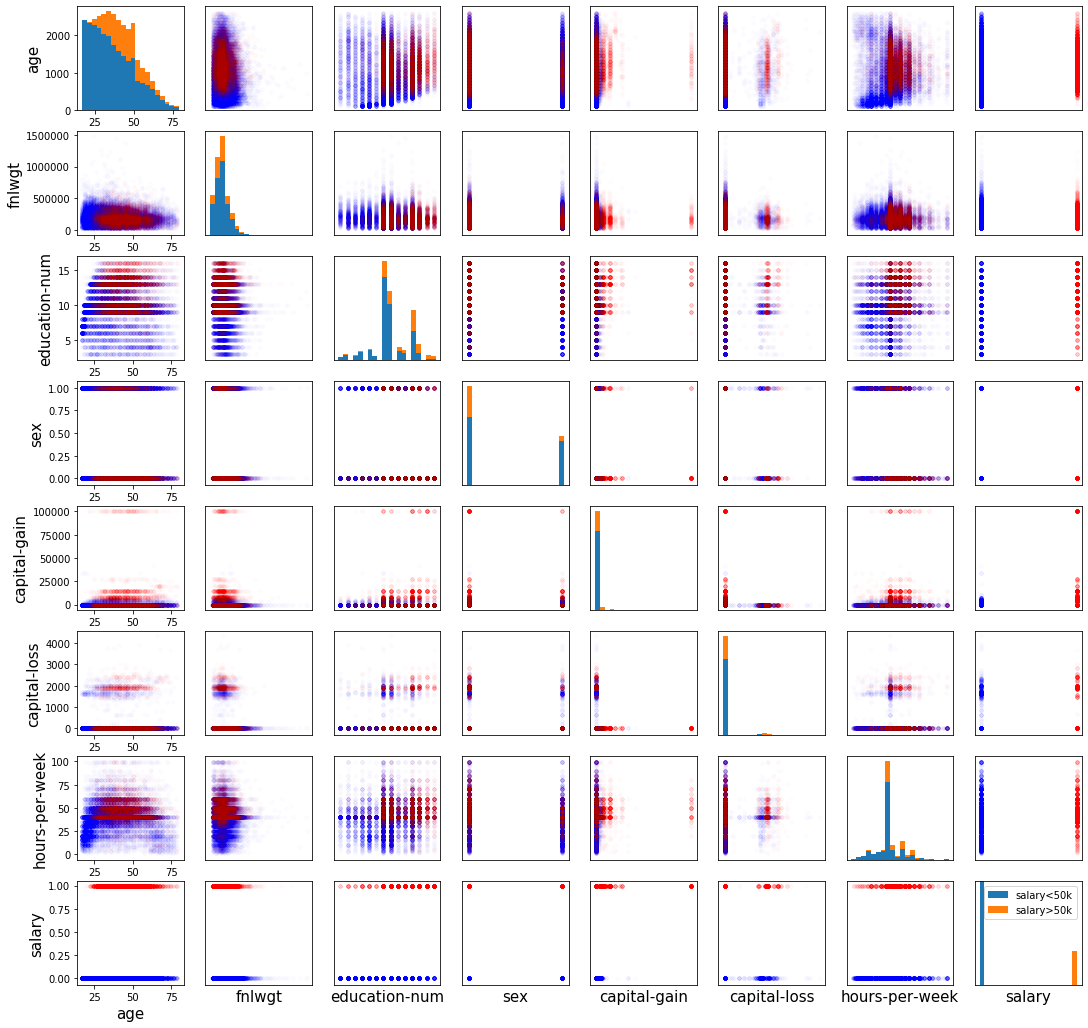

In [21]:
#fig,ax = plt.subplots(3,3,figsize=(10,10))
#columns_lst=['age','fnlwgt','education-num']
fig,ax = plt.subplots(8,8,figsize=(18,18))
columns_lst=['age','fnlwgt','education-num', 
             'sex','capital-gain','capital-loss',
             'hours-per-week','salary']
data1 = data_train[data_train['salary']==0]
data2 = data_train[data_train['salary']==1]
for i,rows in enumerate (columns_lst):
    for j,cols in enumerate (columns_lst):
        if i!= j:
            ax[i][j].scatter(data1[cols],data1[rows],alpha=0.01,c='blue',s=15)
            ax[i][j].scatter(data2[cols],data2[rows],alpha=0.01,c='red',s=15)
        if i ==j:
            ax[i][j].hist([data1[cols],data2[cols]],bins=20,histtype = 'barstacked')
            if i == len(columns_lst)-1:
                ax[i][j].legend(['salary<50k','salary>50k'])             
        if j ==0:
            ax[i][j].set_ylabel(rows,fontsize=15)
        if i == len(columns_lst)-1:
            ax[i][j].set_xlabel(cols,fontsize=15)
        if j>0 and i<len(columns_lst):
            ax[i][j].get_xaxis().set_ticks([])
            ax[i][j].get_yaxis().set_ticks([])

### 2-D Covariance and 1-D Shaprio Ranking of Numerical Features

C:\Users\Yushang\Anaconda3\lib\site-packages\yellowbrick\features\rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


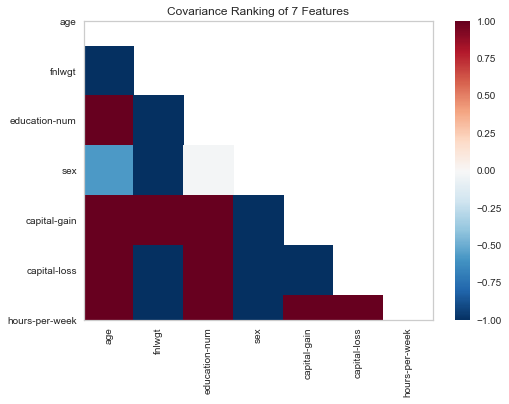

C:\Users\Yushang\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


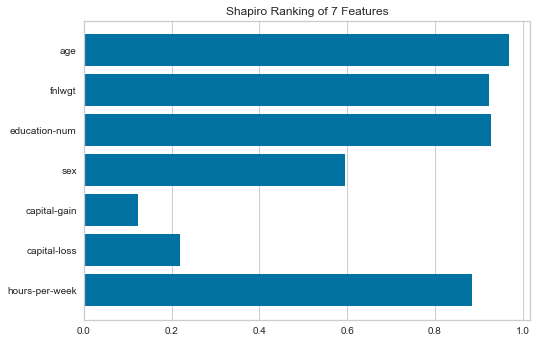

In [22]:
# https://www.scikit-yb.org/en/latest/api/features/rankd.html
#! conda install -c districtdatalabs yellowbrick
from yellowbrick.features import Rank2D
from yellowbrick.features import Rank1D
visualizer = Rank2D(algorithm='covariance')
visualizer.fit(data_train[['age','fnlwgt','education-num', 
             'sex','capital-gain','capital-loss',
             'hours-per-week']], data_train['salary'])           # Fit the data to the visualizer
visualizer.transform(data_train[['age','fnlwgt','education-num', 
             'sex','capital-gain','capital-loss',
             'hours-per-week']])        # Transform the data
visualizer.show()              # Finalize and render the figure
visualizer = Rank1D(algorithm='shapiro')
visualizer.fit(data_train[['age','fnlwgt','education-num', 
             'sex','capital-gain','capital-loss',
             'hours-per-week']], data_train['salary'])           # Fit the data to the visualizer
visualizer.transform(data_train[['age','fnlwgt','education-num', 
             'sex','capital-gain','capital-loss',
             'hours-per-week']])        # Transform the data
visualizer.show()              # Finalize and render the figure

### Imputation Missing Value by M

In [23]:
data_train = data_train.replace(to_replace='?',value=np.nan)
data_test = data_test.replace(to_replace='?',value=np.nan)

In [24]:
data_train.iloc[[27]]     # missing value are replaced by NaN 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
27,54,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,0,0,0,60,South,1


In [25]:
data_test.iloc[[6]]  

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
6,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,0,0,0,40,United-States,0


### Use Pandas Most Frequent Imputer

In [26]:
data = pd.concat([data_train, data_test],axis=0)
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,0,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,0,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,1,0,0,36,United-States,0
16277,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,0,0,0,40,United-States,0
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,0,0,0,50,United-States,0
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,0,5455,0,40,United-States,0


In [27]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")
data1 = imp.fit_transform(data)
data = pd.DataFrame(data1,columns = data.columns)
data.loc[[27]]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
27,54,Private,180211,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,0,0,0,60,South,1


### Change Category type into Boolean Type

In [28]:
categorical_columns = ['education','workclass', 'marital-status', 'occupation', 'relationship','race', 'native-country']
one_hot_df = pd.DataFrame()
for col in categorical_columns:
    one_hot_columns = pd.get_dummies(pd.Categorical(data[col]), prefix = col)
    print('number of added columns (%s): %d' % (col, one_hot_columns.shape[1]))
    one_hot_df = pd.concat([one_hot_df, one_hot_columns], axis=1)

number of added columns (education): 16
number of added columns (workclass): 8
number of added columns (marital-status): 7
number of added columns (occupation): 14
number of added columns (relationship): 6
number of added columns (race): 5
number of added columns (native-country): 41


In [29]:
data = data.reset_index()
data = pd.concat([data, one_hot_df], axis=1)
data = data.drop(columns=categorical_columns)
data = data.drop(columns=['index'])
data

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,salary,education_10th,education_11th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,0,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,0,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48501,39,215419,13,1,0,0,36,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48502,64,321403,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48503,38,374983,13,0,0,0,50,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48504,44,83891,13,0,5455,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0


###   not Drop Capital-gain and Capital-loss

In [30]:
import copy
data_train_new = copy.copy(data.iloc[0:len(data_train),]) 
data_test_new = copy.copy(data.iloc[len(data_train):,]) 
#data_train_new = data_train_new.drop(columns=['capital-gain','capital-loss']) 
#data_test_new = data_test_new.drop(columns=['capital-gain','capital-loss'])

### Data Standization

In [34]:
new_train = data_train['age'] * data_train['hours-per-week']
new_test  = data_test['age'] * data_test['hours-per-week']
data_train['interaction'] = new_train
data_test['interaction'] = new_test

In [36]:
data_train_to_st = data_train[['age','fnlwgt','education-num','hours-per-week','interaction']]
data_test_to_st = data_test[['age','fnlwgt','education-num','hours-per-week','interaction']]
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data_train_to_st)
data_train_st =scaler.transform(data_train_to_st)
data_test_st =scaler.transform(data_test_to_st)
data_train_new[['age','fnlwgt','education-num','hours-per-week','interaction']] = data_train_st
data_test_new[['age','fnlwgt','education-num','hours-per-week','interaction']] = data_test_st

C:\Users\Yushang\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  import sys
C:\Users\Yushang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [37]:
data_train_new.to_csv('training_preprocessed.csv')
data_test_new.to_csv('test_preprocessed.csv')

### Random Forest Feature Importance

In [55]:
data_train = pd.read_csv('./data/adult.data',delimiter=',',skipinitialspace=True)

data_train = data_train.replace(to_replace='?',value=np.nan)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")
data1 = imp.fit_transform(data_train)
data_train = pd.DataFrame(data1,columns = data_train.columns)

Automatically created module for IPython interactive environment


C:\Users\Yushang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF train accuracy: 0.978
RF test accuracy: 0.779


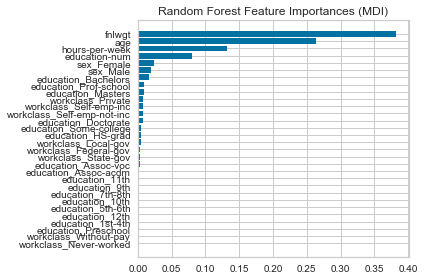

In [56]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
# from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

data_train = pd.read_csv('./data/adult.data',delimiter=',',skipinitialspace=True)

data_train = data_train.replace(to_replace='?',value=np.nan)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")
data1 = imp.fit_transform(data_train)
data_train = pd.DataFrame(data1,columns = data_train.columns)

salary_labels = data_train['salary'].unique()
for i,l in enumerate(salary_labels):
    data_train.loc[data_train['salary'] == l,'salary'] = i%2

categorical_columns = ['workclass', 'education', 'sex']
numerical_columns = ['age','fnlwgt','education-num',
             'hours-per-week']

X = data_train.drop(columns=['salary','capital-gain', 'capital-loss', 
                             'native-country','occupation','marital-status', 'relationship', 'race',])
y = data_train['salary'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

C:\Users\Yushang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF train accuracy: 0.977
RF test accuracy: 0.776


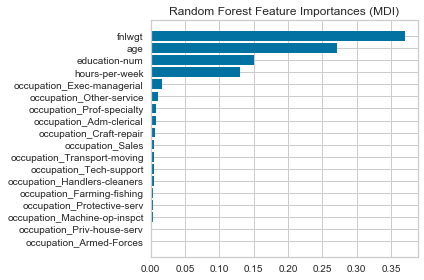

In [57]:
data_train = pd.read_csv('./data/adult.data',delimiter=',',skipinitialspace=True)

data_train = data_train.replace(to_replace='?',value=np.nan)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")
data1 = imp.fit_transform(data_train)
data_train = pd.DataFrame(data1,columns = data_train.columns)

salary_labels = data_train['salary'].unique()
for i,l in enumerate(salary_labels):
    data_train.loc[data_train['salary'] == l,'salary'] = i%2

categorical_columns = ['occupation']
numerical_columns = ['age','fnlwgt','education-num',
             'hours-per-week']

X = data_train.drop(columns=['native-country','salary','capital-gain', 'capital-loss',
                             'marital-status', 'relationship', 'race'
                            ,'workclass', 'education', 'sex'])
y = data_train['salary'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

C:\Users\Yushang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF train accuracy: 0.977
RF test accuracy: 0.768


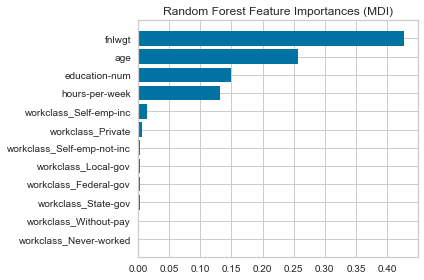

In [58]:
data_train = pd.read_csv('./data/adult.data',delimiter=',',skipinitialspace=True)

data_train = data_train.replace(to_replace='?',value=np.nan)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")
data1 = imp.fit_transform(data_train)
data_train = pd.DataFrame(data1,columns = data_train.columns)

salary_labels = data_train['salary'].unique()
for i,l in enumerate(salary_labels):
    data_train.loc[data_train['salary'] == l,'salary'] = i%2

categorical_columns = ['workclass']
numerical_columns = ['age','fnlwgt','education-num',
             'hours-per-week']

X = data_train.drop(columns=['native-country','salary','capital-gain', 'capital-loss',
                             'marital-status', 'relationship', 'race'
                            , 'education', 'sex','occupation'])
y = data_train['salary'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()